In [1]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# ADD features (year, month, week of year, week of month)
# Split the date into different components
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekofmonth'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)
df['weekday'] = df['date'].dt.weekday
df['hijri'] = df['date'].apply(lambda d: convert.Gregorian(d.year, d.month, d.day).to_hijri())
df['hijri_month'] = df['hijri'].apply(lambda h: h.month)
df['hijri_day'] = df['hijri'].apply(lambda h: h.day)

# Drop the original date column
# df = df.drop('date', axis=1)
df = df.set_index('date')
df = df.sort_index()
df = df.drop('hijri', axis =1 )

df

,y,org,kode_org,des,kode_des,day,month,year,weekofmonth,weekday,hijri_month,hijri_day
date,,,,,,,,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256,13,11,2020,2,4,3,27
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974,17,11,2020,3,1,4,2
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893,17,11,2020,3,1,4,2
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971,17,11,2020,3,1,4,2
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975,17,11,2020,3,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972,4,4,2023,1,1,9,13
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685,5,4,2023,1,2,9,14
2023-04-05,10000000.0,BIAK,973,SURABAYA,563,5,4,2023,1,2,9,14


In [3]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['date','year','month','day','weekofmonth','weekday','hijri_month','hijri_day'])['y'].sum()
data = pd.DataFrame(data)
data = data.reset_index()
data = data.set_index('date')
# Resample to weekly frequency
data = data.resample('W').sum()
data = data.reset_index()
data = data.set_index(['year','month','day','weekofmonth','weekday','hijri_month','hijri_day'])
data = data.drop('date', axis =1 )
data

y
year  month day weekofmonth weekday hijri_month hijri_day             
2020  11    18  3           2       4           3           21891600.0
8080  44    109 17          17      16          49          82167900.0
4040  23    32  6           2       8           32          25570700.0
      24    24  4           10      8           54          33002000.0
6060  36    45  8           3       13          60          81230000.0
...                                                                ...
12138 18    53  10          17      48          101        589943335.0
            96  16          18      48          144        142535977.0
14161 21    161 26          21      60          97         785915116.0
8092  13    85  14          8       36          28         250352469.0
2023  4     9   2           6       9           18           1510000.0

[125 rows x 1 columns]

In [4]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year  month day weekofmonth weekday hijri_month hijri_day             
2020  11    18  3           2       4           3           21891600.0
8080  44    109 17          17      16          49          82167900.0
4040  23    32  6           2       8           32          25570700.0
      24    24  4           10      8           54          33002000.0
6060  36    45  8           3       13          60          81230000.0
...                                                                ...
12138 18    53  10          17      48          101        589943335.0
            96  16          18      48          144        142535977.0
14161 21    161 26          21      60          97         785915116.0
8092  13    85  14          8       36          28         250352469.0
2023  4     9   2           6       9           18           1510000.0

[124 rows x 1 columns]

In [5]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [6]:
len(data)

124

In [7]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [8]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)



In [9]:
scaled_train[:10]

array([[0.02638148],
       [0.0990202 ],
       [0.03081514],
       [0.03977057],
       [0.09788994],
       [0.00697618],
       [0.11014643],
       [0.        ],
       [0.10328744],
       [0.02638148]])

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
84/84 [==============================] - 2s 4ms/step - loss: 0.0609
Epoch 2/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 3/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0369
Epoch 4/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 5/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0339
Epoch 6/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0350
Epoch 7/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0351
Epoch 8/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0358
Epoch 9/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0323
Epoch 10/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0324
Epoch 11/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 12/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 13/50
84/84 [==============================

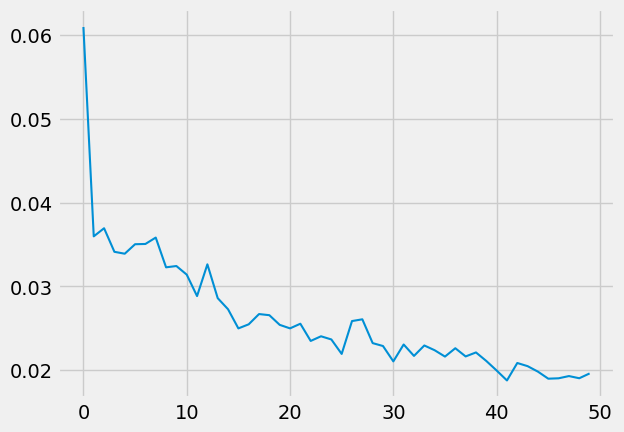

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 436ms/step


array([[0.40521014]], dtype=float32)

In [17]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [18]:
test_predictions

[array([0.40521014], dtype=float32),
 array([0.3764035], dtype=float32),
 array([0.47388172], dtype=float32),
 array([0.34038633], dtype=float32),
 array([0.54092044], dtype=float32),
 array([0.3029369], dtype=float32),
 array([0.588043], dtype=float32),
 array([0.2915397], dtype=float32),
 array([0.5994412], dtype=float32),
 array([0.30163112], dtype=float32),
 array([0.56415623], dtype=float32),
 array([0.32596704], dtype=float32),
 array([0.5382659], dtype=float32),
 array([0.34482232], dtype=float32),
 array([0.5399759], dtype=float32),
 array([0.34422958], dtype=float32),
 array([0.5634413], dtype=float32),
 array([0.3281898], dtype=float32),
 array([0.60009354], dtype=float32),
 array([0.3068501], dtype=float32),
 array([0.6349706], dtype=float32),
 array([0.28873566], dtype=float32),
 array([0.6451532], dtype=float32),
 array([0.28859213], dtype=float32),
 array([0.6374641], dtype=float32),
 array([0.2962989], dtype=float32),
 array([0.633041], dtype=float32),
 array([0.29868424

In [19]:
test.head()

,,,,,,,y
year,month,day,weekofmonth,weekday,hijri_month,hijri_day,
14154,63,154,25,21,14,182,270694518.0
12132,56,117,20,21,18,21,252625603.0
14154,70,42,9,21,21,70,397294789.0
12132,60,79,14,19,18,103,299681740.0
14154,70,140,23,21,21,168,558172460.0


In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

In [21]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_19060\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


,,,,,,,y,Predictions
year,month,day,weekofmonth,weekday,hijri_month,hijri_day,,
14154,63,154,25,21,14,182,270694518.0,3.362472e+08
12132,56,117,20,21,18,21,252625603.0,3.123432e+08
14154,70,42,9,21,21,70,397294789.0,3.932316e+08
12132,60,79,14,19,18,103,299681740.0,2.824558e+08
14154,70,140,23,21,21,168,558172460.0,4.488609e+08


<Axes: xlabel='year,month,day,weekofmonth,weekday,hijri_month,hijri_day'>

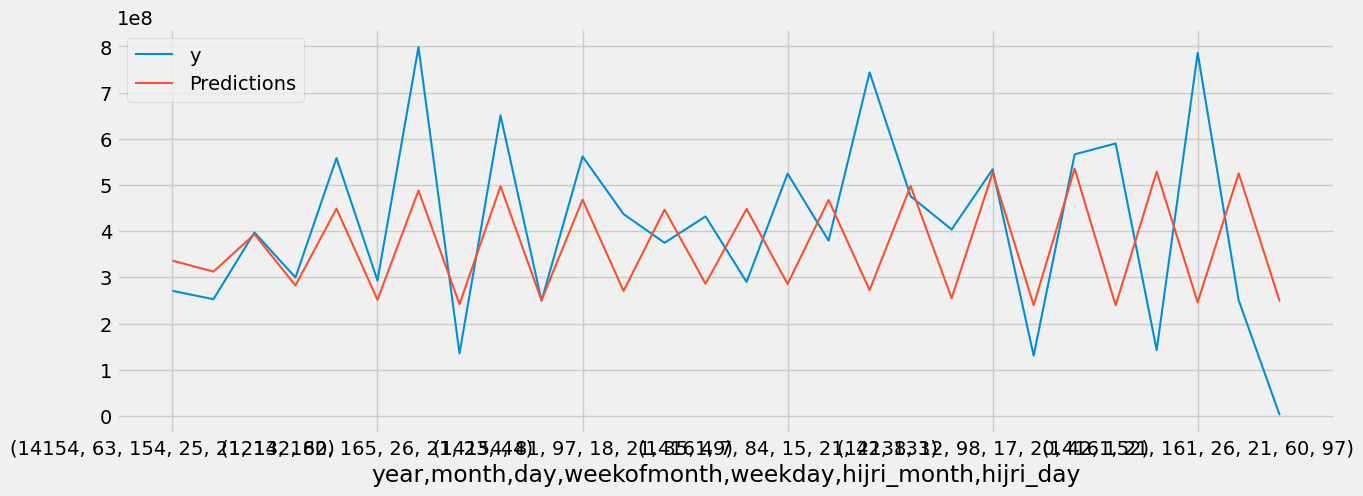

In [22]:
test.plot(figsize=(14,5))

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 212484533.89073697
Mean Value of Test Dataset: 411774556.89285713
